In [1]:
import os
import sys

import numpy
from matplotlib import pyplot as plt
from scipy import stats as stats

from red_likelihood import degVis, doRelCal, doOptCal, doDegVisVis, group_data, gVis, \
makeCArray, red_ant_sep
from red_utils import cplot, find_zen_file, find_nearest, plot_red_vis, split_rel_results

In [2]:
numpy.set_printoptions(threshold=sys.maxsize)

In [3]:
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

In [4]:
pol = 'ee'
freq_channel = 300
time_integration = 1
bad_ants = [0, 2, 11, 24, 50, 53, 54, 67, 69, 98, 122, 136, 139]

In [5]:
filename = find_zen_file(2458098.43869)

In [6]:
hdraw, cRedG, cData = group_data(filename, pol, freq_channel, bad_ants)
ants = numpy.unique(cRedG[:,1:])
no_unq_bls = numpy.unique(cRedG[:, 0]).size

No GPU/TPU found, falling back to CPU.


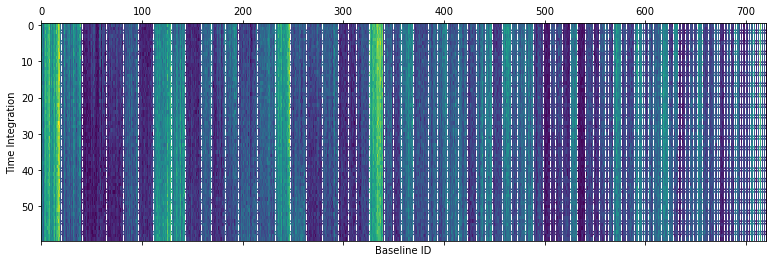

In [7]:
plot_red_vis(cData, cRedG, vis_type='amp')

# Redundant calibration

Fundamentally, the problem of calibration boils down to the measurement equation:

$$ V_{ij}^{\text{obs}} (\nu) = g_i (\nu) g_j^* (\nu) V_{ij}^{\text{true}}(\nu) + n_{ij} (\nu) $$

where the observed visibility $V_{ij}$ between antennas $i$ and $j$ at a given time and frequency is related to the true, underlying visibility by a pair of complex and frequency-dependent gain factors, $g_i$ and $g_j$, if we assume per-antenna gains, along with uncorrelated Gaussian random noise $n_{ij}$. The ultimate aim of calibration is to solve for these gains and visibilities. 

For a redundant array, we have a system of equations for all antenna pairs $i$ and $j$, given by

$$ V_{ij}^{\text{obs}} (\nu) = g_i (\nu) g_j^* (\nu) U_{\alpha}(\nu) $$

where $U_{\alpha}(\nu) = V(\mathbf{r}_i-\mathbf{r}_j)$, the visibility for the baseline vector $ \mathbf{b}_{ij} = \mathbf{r}_i-\mathbf{r}_j$, which corresponds to a redundant baseline set that we index by $\alpha$. Two pairs of identical elements with precisely the same baseline separation between them are sensitive to the same mode on the sky, and are thus measuring the same $V_{ij}^{\text{true}}$.

In highly redundant arrays, there are many more observations than there are unique baselines. For the full HERA array, there are 331 elements in the hexagonal core, corresponding to $N_{\mathrm{bl}} = 331(331-1)/2 = 54,615$ baselines. The hexagonal core only has 630 unique baseline separations, this means we have a non-linear system of $54,615$ equations to determine 630 unique visibilities and the 331 complex gains; the system is vastly overdetermined.

## Relative calibration

### Gaussian distribution

By imposing that the true sky visibilities from redundant baselines are equal, relative redundant calibration solves for the true sky visibilities for each redundant baseline set $V_{i-j}^{\text{sol}}$, alongside the gains of the individual antennas.

Assuming Gaussian uncorrelated noise with variance $\sigma_{ij}^2$, a maximum-likelihood estimate for the gains and sky visibilities can be constructed:

$$ \mathcal{L} (\{g_i(\nu)\}, \{U_{\alpha}(\nu)\} | \{V_{ij}^{\text{obs}}(\nu)\} \propto \prod_{\nu} \prod_{\alpha} \prod_{\{i,j\}_{\alpha}} \exp{\left( -\frac{1}{2} \left( \frac{ \left| V_{ij}^{\text{obs}} (\nu) - g_i (\nu) g_j^{*} (\nu) U_{\alpha}(\nu) \right|^2}{\sigma_{ij}^2(\nu)} \right) \right)} $$

where $\{i,j\}_{\alpha}$ are sets of antennas that belong to each redundant baseline type $\alpha$. Maximizing this function is equivalent to minimizing:

$$ \chi_{\mathrm{rel}}^{2} (\nu) = \sum_{\alpha} \sum_{\{i,j\}_{\alpha}} \frac{ \left| V_{ij}^{\text{obs}} (\nu) - g_i (\nu) g_j^* (\nu) U_{\alpha}(\nu) \right|^2 }{\sigma_{ij}^2(\nu)} $$

by varying $g_k(\nu)$ and $U_{\alpha}(\nu)$ for each frequency $\nu$.

This non-linear least-squares optimization can be done independently between frequencies and time.

### Cauchy distribution

We no longer assume that the noise in the measurement equation is Gaussian. Empirically, it is found that visibility observations can have a lot of outliers, and the visibilities follow a distribution with fatter tails than a Gaussian. We wish to be insensitive to outliers, so we need to employ robust statistics to adequately deal with such measurements.

Instead of fitting the visibilities to a Gaussian, we fit them to a Cauchy distribution, when solving the redundant calibration parameter estimation.

The Cauchy distribution is given by

$$ f(x; x_0, \gamma) = \frac{1}{\pi \gamma \left[ 1 + \left( \frac{x - x_0}{\gamma}  \right)^2  \right] }$$

where $x_0$ is the location parameter (the median) and $\gamma$ is the scale parameter, which specifies the half-width at half-maximum (HWHM).

Working in a maximum likelihood framework, the likelihood when solving for the measurement equation for redundant baseline sets is given by

$$ \mathcal{L} = \prod_{\nu} \prod_{\alpha} \prod_{\{i,j\}_{\alpha}} \frac{1}{\pi \gamma_{\alpha} (\nu)} \left[ 1 + \left( \frac{\left| V_{ij}^{\text{obs}} (\nu) - g_i (\nu) g_j^* (\nu) U_{\alpha}(\nu) \right|}{\gamma_{\alpha} (\nu)}  \right)^2  \right]^{-1} $$

The negative log-likelihood is therefore given by

$$ -\ln(\mathcal{L}) (\nu) = \sum_{\alpha} \sum_{\{i,j\}_{\alpha}} \ln(\pi \gamma_{\alpha} (\nu)) + \ln \left( 1 + \left( \frac{\left| V_{ij}^{\text{obs}} (\nu) - g_i (\nu) g_j^* (\nu) U_{\alpha}(\nu) \right|}{\gamma_{\alpha}(\nu)}  \right)^2 \right) $$

where we have dropped the sum over frequency, as we can solve independently for each frequency.

In [8]:
res_rel = doRelCal(cRedG, cData[time_integration, :], distribution='cauchy')

Optimization terminated successfully.


In [9]:
res_rel_vis, res_rel_gains = split_rel_results(res_rel, no_unq_bls)

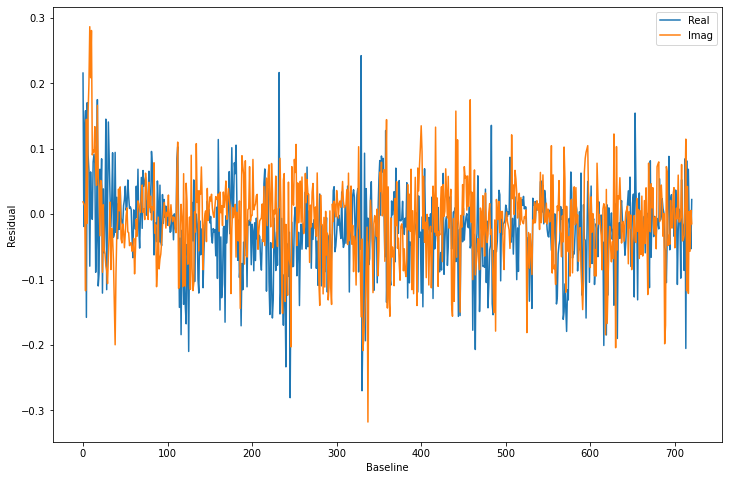

In [10]:
# Residuals for relative redundant step
rel_residuals = cData[time_integration, :] - gVis(res_rel_vis, cRedG, res_rel_gains)
cplot(rel_residuals, xlabel='Baseline', ylabel='Residual')

## Optimal calibration (solving for degeneracies)

Relative calibration yields degenerate solutions, that can be parameterized as four terms per frequency:
 - Overall amplitude $A(\nu)$
 - Overall phase $\Delta(\nu)$
 - Phase gradient components $\Delta_x(\nu)$ and $\Delta_y(\nu)$
 
The below transformations of these degenerate parameters leave $-\ln(\mathcal{L})$ (for both Gaussian and Cauchy distributions) unchanged:
 - $g_i \rightarrow A g_i$ accompanied by $U_{\alpha} \rightarrow A^{-2} U_{\alpha}$
 - $g_k = |g_k|e^{i\phi_k} \rightarrow |g_k|e^{i(\phi_k + \Delta)}$ corresponds to $g_k g_l^{*} = |g_k| |g_l| e^{i(\phi_k - \phi_l)} \rightarrow |g_k| |g_l| e^{i(\phi_k + \Delta - \phi_l - \Delta)} = g_k g_l^{*}$
 - $g_k = |g_k|e^{i\phi_k} \rightarrow |g_k|e^{i(\phi_k + \Delta_x x_k + \Delta_y y_k)}$ accompanied by $U_{\alpha} = |U_{\alpha}| e^{i\phi_{\alpha}} \rightarrow |U_{\alpha}| e^{i(\phi_{\alpha} - \Delta_x x_{\alpha} - \Delta_y y_{\alpha})}$
 
Where in the last line, the array is assumed to be co-planar, and $(x_k, y_k)$ are the coordinates of the position of antennas $k$, and $(x_{\alpha}, y_{\alpha})$ are the separations of the antennas that form baselines in redundant set $\alpha$.

These degeneracies must be constrained - this is the "absolute" part of redundant calibration. The degenerate parameters can either calculated from a sky model, or can be solved for using optimal absolute calibration, which calculates the degenerate parameters directly from the $\chi^2$ or $-\ln(\mathcal{L})$ by applying a few conditions.

 - Gaussian distribution:
 
$$ \chi_{\text{opt}}^2 (\nu) = \sum_{\alpha} \sum_{\{i,j\}_{\alpha}} \frac{ \left|  V_{ij}^{\text{obs}} (\nu) - h_i (\nu) h_j^{*} (\nu) W_{\alpha} (\nu) \right|^2 }{\sigma_{ij}^2(\nu)} $$


where

$$ W_{\alpha} (\nu) = A^2(\nu) e^{i \left[ \Delta_{x} (\nu) x_{\alpha} + \Delta_{y} (\nu) y_{\alpha} \right]} U_{\alpha} $$

In [11]:
res_opt = doOptCal(cRedG, cData[time_integration, :], hdraw.antpos, res_rel_vis, \
                   distribution='gaussian', ref_ant=12)

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.


`xtol` termination condition is satisfied.


In [12]:
new_gain_params, new_deg_params = numpy.split(res_opt['x'], [ants.size*2,])
new_gains = makeCArray(new_gain_params)

In [13]:
print('Degenerate parameters: {}'.format(str(new_deg_params)[1: -1]))
print('Amplitude average: {}'.format(numpy.average(numpy.abs(new_gains))))
print('Phase circular mean: {}'.format(stats.circmean(numpy.angle(new_gains))))

Degenerate parameters:  8.94196922e-02  1.51202361e-05 -8.77002473e-03  8.74623586e-03
Amplitude average: 1.0000000000000642
Phase circular mean: 9.553782743300485e-15


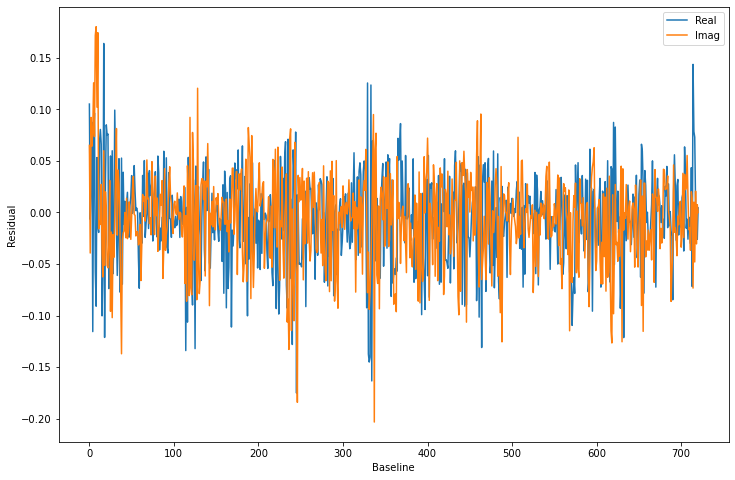

In [14]:
# Residuals for optimal redundant step
ant_sep = red_ant_sep(cRedG, hdraw.antpos)
opt_w_alpha = degVis(ant_sep, res_rel_vis, *new_deg_params[[0, 2, 3]])
opt_residuals =  cData[time_integration, :] - gVis(opt_w_alpha, cRedG, new_gains)
cplot(opt_residuals, xlabel='Baseline', ylabel='Residual')

# Comparing relative calibrations

To monitor the consistency of the "true" visibility solutions for each baseline set, we calculate the relative calibration visibility solutions from another JD and compare them to the relative solutions of the initial dataset. These should be consistent, up to the degenerate parameters $A$, $\Delta$, $\Delta_x$ and $\Delta_y$ - solving for these parameters with an MLE framework enables us to compare these solutions.

We need to minimize:

- Assuming Gaussian distributions:

$$ \chi^2_{\text{deg}} (\nu) = \sum_{\alpha} \sum_{\{i,j\}_{\alpha}} \frac{ \left| U_{\alpha}' (\nu) - W_{\alpha} (\nu) \right|^2 }{\sigma_{\alpha}^2(\nu)} $$

- Assuming Cauchy distributions:

$$-\ln(\mathcal{L}) = \sum_{\alpha} \sum_{\{i,j\}_{\alpha}} \ln(\pi \gamma_{\alpha}) + \ln \left( 1 + \left( \frac{\left| U_{\alpha}' (\nu) - W_{\alpha} (\nu) \right|}{\gamma_{\alpha}}  \right)^2 \right) $$

In [15]:
filename2 = find_zen_file(2458099.43869)

In [16]:
hdraw2, cRedG2, cData2 = group_data(filename2, pol, freq_channel, bad_ants)
no_unq_bls2 = numpy.unique(cRedG2[:, 0]).size
print('Do {} and {} have the same redundant grouping? {}'.format(os.path.basename(filename), \
      os.path.basename(filename2), (cRedG==cRedG2).all()))

Do zen.2458098.43869.HH.uvh5 and zen.2458099.43869.HH.uvh5 have the same redundant grouping? True


In [17]:
# Find time integration in dataset 2 that corresponds to closest LST to that of dataset 1
# This currently assumes that dataset 2 contains the correct time integration...
time_integration2 = find_nearest(hdraw2.lsts, hdraw.lsts[time_integration])[1]

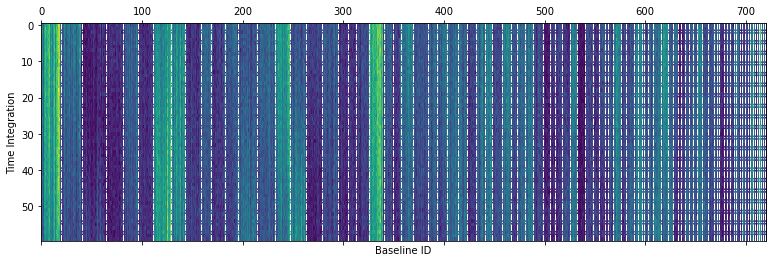

In [18]:
plot_red_vis(cData2, cRedG2, vis_type='amp')

In [19]:
# Relative calibration for the 2nd dataset
res_rel2 = doRelCal(cRedG2, cData2[time_integration2, :], distribution='cauchy')

Optimization terminated successfully.


In [20]:
res_rel_vis2, res_rel_gains2 = split_rel_results(res_rel2, no_unq_bls2)

In [21]:
res_deg = doDegVisVis(cRedG, hdraw.antpos, res_rel_vis, res_rel_vis2, distribution='cauchy')

Optimization terminated successfully.


In [22]:
deg_tr_params = res_deg['x']
print(deg_tr_params)

[ 0.98113137  0.         -0.00120354 -0.0010882 ]


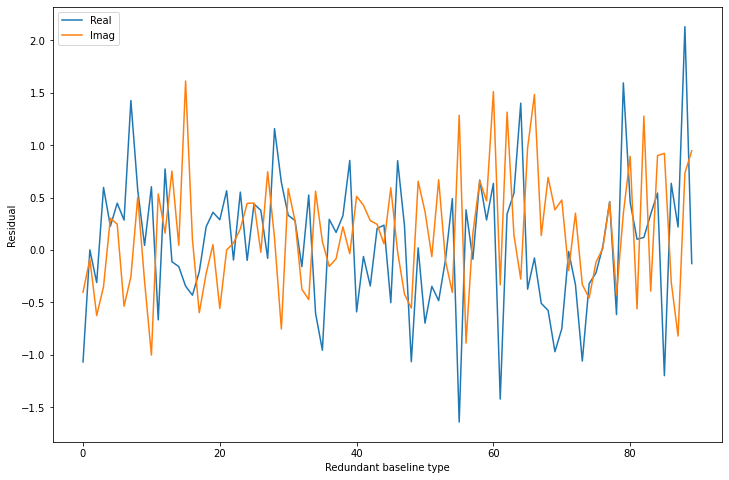

In [23]:
# Residuals for degenerate comparison
deg_w_alpha = degVis(ant_sep, res_rel_vis, *deg_tr_params[[0, 2, 3]])
deg_residuals = res_rel_vis2 - deg_w_alpha
cplot(deg_residuals, xlabel='Redundant baseline type', ylabel='Residual')